In [1]:
# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import dalex as dx
from keras.saving import load_model
from sklearn.preprocessing import \
    (StandardScaler, OneHotEncoder,
    LabelEncoder, PolynomialFeatures, OrdinalEncoder)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import \
    (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score)

In [2]:
# Adjust default matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.frameon'] = True
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
# Read in data
df_cces = pd.read_parquet('../Data/CCES/CCES_Panel_cleaned.parquet')

In [4]:
df_cces

,caseid,weight,year,301_1,301_2,301_3,301_4,301_5,301b,302,...,pew_churatd,pew_prayer,pew_religimp,phone,pid3,pid7,race,religpew,union,unionhh
0,25233,0.538062,2010,Yes,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once or twice a month,A few times a week,Somewhat important,Both,Independent,Lean Republican,White,Roman Catholic,Formerly,"No, never"
1,38716,3.470877,2010,Yes,No,Yes,Yes,No,NaN,Stayed about the same,...,Never,Never,Not at all important,Cell only,Democrat,Not very strong Democrat,White,Nothing in particular,"No, never","No, never"
2,7796,0.602477,2010,No,Yes,Yes,Yes,No,Both,Gotten worse,...,More than once a week,Several times a day,Very important,Both,Republican,Strong Republican,White,Mormon,Formerly,Formerly
3,78113,0.264208,2010,Yes,Yes,Yes,Yes,No,Both,Gotten better,...,Never,Never,Not at all important,Cell only,Democrat,Strong Democrat,White,Nothing in particular,"No, never","No, never"
4,63800,0.196632,2010,Yes,Yes,Yes,No,No,Both,Gotten better,...,Seldom,Never,Not too important,Both,Democrat,Strong Democrat,White,Protestant,"No, never","No, never"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,57290,1.146715,2014,No,No,No,No,Yes,NaN,Gotten better,...,Never,A few times a month,Somewhat important,Cell only,Democrat,Strong Democrat,Hispanic,Something else,"No, never",Formerly
28496,57315,1.171217,2014,No,No,No,No,Yes,NaN,Stayed about the same,...,A few times a year,A few times a week,Somewhat important,Cell only,Republican,Strong Republican,Hispanic,Roman Catholic,"No, never","No, never"
28497,57399,0.424949,2014,No,Yes,No,No,No,Local Newscast,Gotten much better,...,Never,Seldom,Not at all important,Both,Democrat,Strong Democrat,Hispanic,Something else,"No, never",Formerly
28498,59331,0.505942,2014,No,Yes,No,Yes,No,Local Newscast,Gotten worse,...,Once a week,Once a day,Very important,Cell only,Republican,Strong Republican,Hispanic,Mormon,"Yes, currently","No, never"


In [5]:
# Sort values to create lagged dv
df_cces = df_cces.sort_values(['caseid', 'year']) \
    .reset_index(drop=True)

In [6]:
df_cces

,caseid,weight,year,301_1,301_2,301_3,301_4,301_5,301b,302,...,pew_churatd,pew_prayer,pew_religimp,phone,pid3,pid7,race,religpew,union,unionhh
0,1,0.956946,2010,No,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once a week,Once a day,Very important,Both,Republican,Strong Republican,White,Protestant,"No, never","No, never"
1,1,0.956946,2012,No,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once a week,Several times a day,Very important,Cell only,Republican,Strong Republican,White,Protestant,"No, never","No, never"
2,1,0.956946,2014,No,Yes,Yes,Yes,No,National Newscast,Gotten worse,...,Once or twice a month,Several times a day,Very important,Both,Republican,Not very strong Republican,White,Protestant,"No, never","No, never"
3,24,1.847343,2010,Yes,Yes,Yes,No,No,National Newscast,Stayed about the same,...,Never,Never,Not at all important,Both,Republican,Not very strong Republican,White,Agnostic,"No, never","No, never"
4,24,1.847343,2012,Yes,Yes,Yes,No,No,Both,Gotten better,...,Never,Never,Not at all important,Both,Independent,Independent,White,Atheist,"No, never","No, never"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,85318,1.747243,2012,No,Yes,Yes,No,No,Both,Gotten better,...,Never,Never,Not at all important,Both,Independent,Independent,White,Something else,"Yes, currently","No, never"
28496,85318,1.747243,2014,No,Yes,No,No,No,NaN,Stayed about the same,...,Never,Never,Not at all important,Both,Independent,Lean Democrat,White,Something else,"No, never","Yes, currently"
28497,85321,0.753324,2010,No,Yes,No,Yes,No,Both,Gotten much worse,...,Seldom,Several times a day,Somewhat important,Both,Republican,Strong Republican,White,Protestant,"No, never","No, never"
28498,85321,0.753324,2012,No,Yes,No,No,No,Both,Gotten much worse,...,Never,Several times a day,Very important,Both,Independent,Lean Republican,White,Protestant,"No, never","No, never"


In [7]:
# Create lag of the DV
df_cces['VV_primary_lag'] = df_cces.groupby('caseid')['VV_primary'].shift(1)
df_cces['VV_general_lag'] = df_cces.groupby('caseid')['VV_general'].shift(1)

In [8]:
# Check
df_cces[['caseid', 'year', 'VV_primary_lag', 'VV_primary']]

,caseid,year,VV_primary_lag,VV_primary
0,1,2010,NaN,Voted
1,1,2012,Voted,Voted
2,1,2014,Voted,Voted
3,24,2010,NaN,Voted
4,24,2012,Voted,Voted
...,...,...,...,...
28495,85318,2012,Abstained,Abstained
28496,85318,2014,Abstained,Abstained
28497,85321,2010,NaN,Abstained
28498,85321,2012,Abstained,Abstained


In [9]:
# Drop all rows where lag is missing = 2010
df_cces = df_cces.query('year != 2010').copy()

In [10]:
# Convert cdid to category to create dummies for district ID
df_cces['cdid'] = df_cces['cdid'].astype('category')

In [11]:
# Drop caseid and weight
df_cces = df_cces.drop(['caseid', 'weight'], axis=1)

In [12]:
# Select theoretically relevant features
col_select = [
    'year', 'birthyr', 'gender', 'educ', 'race', 'hispanic', 'employ', 'marstat', 'pid7',
    'ideo5', 'child18', 'newsint', 'faminc', 'ownhome', 'milstat_1', 'milstat_3', 'citylength_1',
    'addrlength_1', 'immstat', 'union', 'unionhh', '301_1', '301_2', '301_3', '301_4', '301_5',
    '302', '308b', '309a', '309b', '309c', '309d', '316', '350', '417a_1', '417a_2', '417a_3',
    '417a_4', '417a_5', '417a_6', '418a', '425a', '425b_1', '425b_2', '425b_3', '425b_4',
    'VV_primary', 'VV_general', 'inputstate', 'pew_churatd', 'cdid', 'VV_primary_lag',
    'VV_general_lag'
]
df_cces = df_cces[col_select]

In [13]:
# Write function to split into training and test set
def split_cces(df):
    df_train = df.query('year == 2012') \
        .drop('year', axis=1)
    df_test = df.query('year == 2014') \
        .drop('year', axis=1)
    
    return (df_train, df_test)

In [14]:
# Define class for metrics
class Metrics:
    
    def __init__(self, conf_matrix):
        """
        Initialize the Metrics object with true labels and predicted labels.
        """
        self.conf_matrix = conf_matrix
        self.TN, self.FP, self.FN, self.TP = self.conf_matrix.ravel()

    def accuracy(self):
        """
        Compute accuracy
        """
        return (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN)

    def recall(self):
        """
        Compute recall (sensitivity or TPR)
        """
        return self.TP / (self.TP + self.FN) if (self.TP + self.FN) != 0 else 0

    def specificity(self):
        """
        Computr specificity (TNR)
        """
        return self.TN / (self.TN + self.FP) if (self.TN + self.FP) != 0 else 0

    def precision(self):
        """
        Compute precision
        """
        return self.TP / (self.TP + self.FP) if (self.TP + self.FP) != 0 else 0

    def f1_score(self):
        """
        Compute F1 score
        """
        precision = self.precision()
        recall = self.recall()
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

In [15]:
# Write function to visualize training process

def plot_train_proc(df_metrics, filename):
    
    plt.figure(figsize=(12,6))
    plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
            label='Training Accuracy', color='red')
    plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
            label='Validation Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.xticks(np.linspace(0, 50, 11).astype(int))
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, format='svg')

In [16]:
# Define custom predict function for explainer
def custom_predict(model, data):
    preds_proba = model.predict(data).flatten()
    preds = (preds_proba > .5).astype(int)
    return preds

In [17]:
# Write function to visualize variable importance. I don't like the custom plot.
def plot_varimp(varimp_object, max_vars, file_name):
    
    # Prepare data frame
    df_temp = varimp_object.result.drop('label', axis=1)
    df_temp['diff'] = df_temp['dropout_loss'] - df_temp.iloc[16,1]
    df_temp.sort_values('diff', ascending=True, inplace=True)
    df_temp = df_temp.loc[df_temp['variable'] != '_baseline_']
    full_model_loss = df_temp.loc[df_temp['variable'] == '_full_model_']['dropout_loss'].values[0]
    df_temp.reset_index(drop=True, inplace=True)
    df_temp = df_temp.tail(max_vars)
    
    # Plot
    plt.figure(figsize=(12,8))
    bars = plt.barh(df_temp['variable'], df_temp['dropout_loss'])
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.002, bar.get_y() + bar.get_height() / 2, f'+{width - full_model_loss:.3f}', va='center', size=16)
        
    plt.xlabel('Dropout Loss (Loss function: $1-\\text{AUC}$)')
    plt.ylabel(None)
    plt.xlim(left=full_model_loss)
    plt.grid(True)
    plt.gca().yaxis.set_tick_params(pad=15)
    plt.savefig(file_name, format='svg')

# DV: VV_primary, incl. lag

## Preprocessing

In [18]:
df_cces_1 = df_cces.drop(['VV_general_lag', 'VV_general'], axis=1)

In [19]:
# Split into training and test set
df_train, df_test = split_cces(df_cces_1)

In [20]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [21]:
X_train = df_train.drop('VV_primary', axis=1)
y_train = df_train['VV_primary'].to_numpy()
X_test = df_test.drop('VV_primary', axis=1)
y_test = df_test['VV_primary'].to_numpy()

In [22]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [23]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [24]:
# One-hot encode only unordered categorical columns
# Ordered categorical columns are ordinally encoded
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan), 
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [25]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [26]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to test features
X_test = pipe.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
# Check shape
X_train.shape[1] # 218 features

218

## Import model

In [28]:
# Load model with lowest validation loss
model1 = load_model('../Data/TF+Models/best_model1.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluate

In [18]:
# Visualize training and validation loss during training process
df_metrics1 = pd.read_csv('../Data/TF+Models/training_log1.csv')

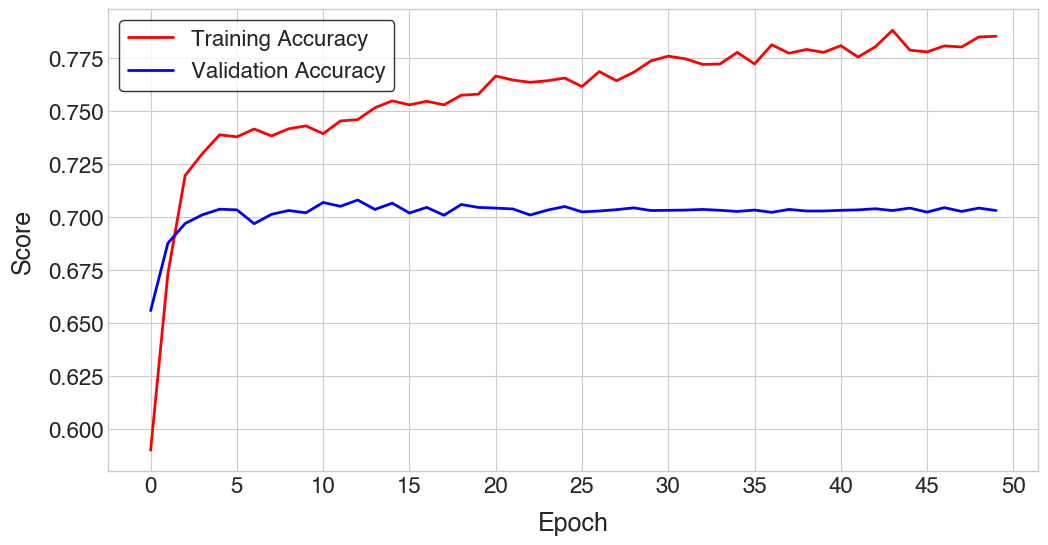

In [19]:
plot_train_proc(df_metrics1, filename='train_proc_1.svg')

In [31]:
preds_proba1_train = model1.predict(X_train).flatten()
preds1_train = (preds_proba1_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds1_train == y_train)/len(y_train):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
Training accuracy: 0.780


In [32]:
preds_proba1_test = model1.predict(X_test).flatten()
preds1_test = (preds_proba1_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds1_test == y_test)/len(y_test):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
Test accuracy: 0.708


In [33]:
cmat1 = confusion_matrix(y_true=y_test, y_pred=preds1_test)
cmat1_disp = ConfusionMatrixDisplay(cmat1, display_labels=y_encoder.classes_)

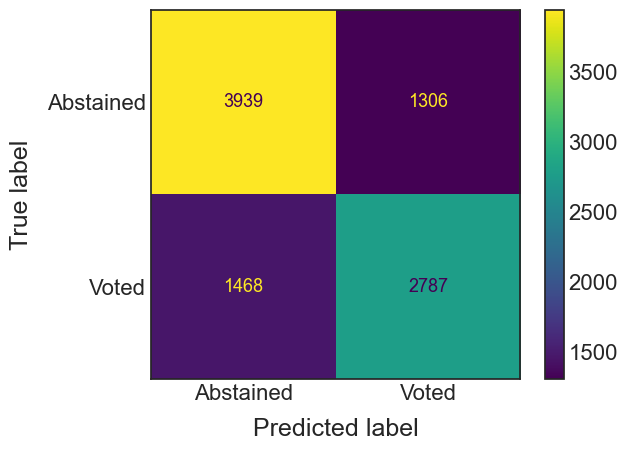

In [34]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat1_disp.plot();

In [35]:
# Additional metrics for performance on test data
metrics1 = Metrics(cmat1)
print(f'Accuracy: {metrics1.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics1.recall():.2%}')
print(f'Specificity (TNR): {metrics1.specificity():.2%}')
print(f'Precision: {metrics1.precision():.2%}')
print(f'F1: {metrics1.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba1_test):.2f}')

Accuracy: 70.80%
Sensitivity/Recall (TPR): 65.50%
Specificity (TNR): 75.10%
Precision: 68.09%
F1: 0.67
AUC: 0.75


## Explain

In [36]:
# Create explainer
expl1 = dx.Explainer(model1, X_test, y_test, predict_function=custom_predict)

Preparation of a new explainer is initiated

  -> data              : 9500 rows 218 cols
  -> target variable   : 9500 values
  -> model_class       : keras.models.sequential.Sequential (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x30c4b4040> will be used
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
  -> predicted values  : min = 0.0, mean = 0.431, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
  -> residuals         : min = -1.0, mean = 0.0171, max = 1.0
  -> model_info        : package keras

A new explainer has been created!


In [37]:
# Create dictionary to map original feature names to dummies
features = df_train.drop('VV_primary', axis=1).columns
feat_dict = {feat: [col for col in X_train.columns if col.startswith(feat)] for feat in features}
feat_dict['birthyr'] = ['remainder__birthyr']
feat_dict['citylength_1'] = ['remainder__citylength_1']
feat_dict['addrlength_1'] = ['remainder__addrlength_1']

In [38]:
# Compute variable importance with 10 permutation rounds
var_imp1 = expl1.model_parts(variable_groups=feat_dict, loss_function='1-auc', 
                             N=None, B=10, random_state=42)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
297/297 ━━━

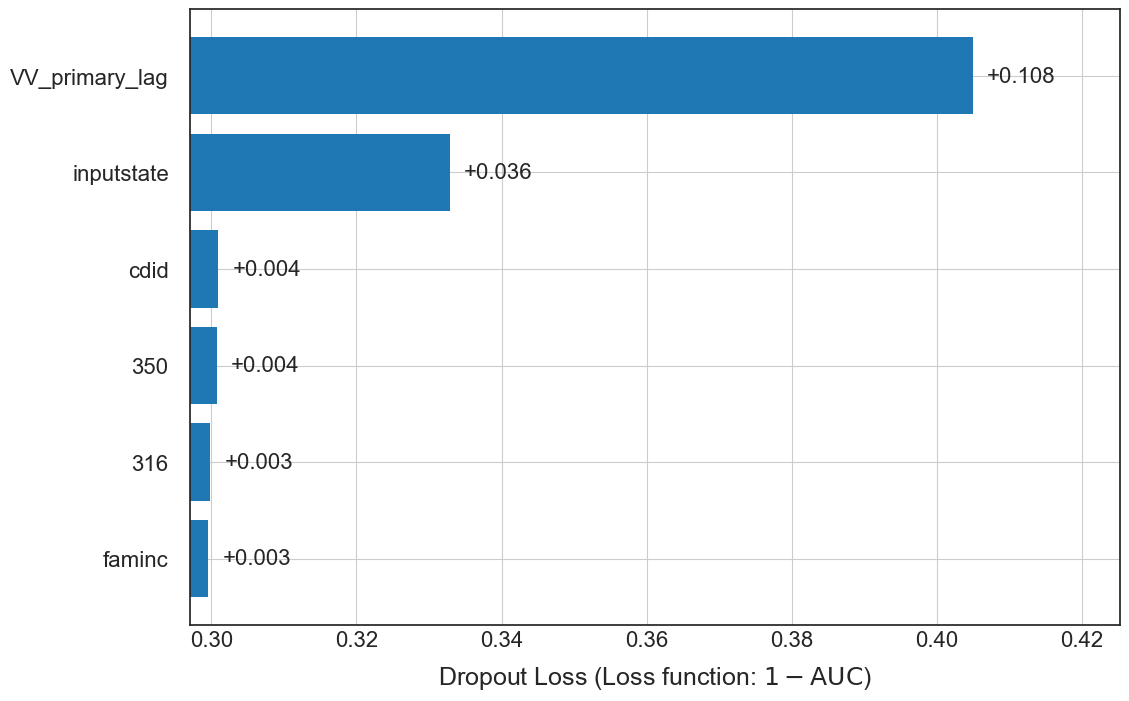

In [39]:
plot_varimp(var_imp1, max_vars=6, file_name='var_imp_1_nn.svg')

# DV: VV_primary, excl. lag

## Preprocessing

In [40]:
df_cces_2 = df_cces.drop(['VV_general_lag', 'VV_general', 'VV_primary_lag'], axis=1)

In [41]:
# Split into training and test set
df_train, df_test = split_cces(df_cces_2)

In [42]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [43]:
X_train = df_train.drop('VV_primary', axis=1)
y_train = df_train['VV_primary'].to_numpy()
X_test = df_test.drop('VV_primary', axis=1)
y_test = df_test['VV_primary'].to_numpy()

In [44]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [45]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [46]:
# One-hot encode only unordered categorical columns
# Ordered categorical columns are ordinally encoded
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan), 
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [47]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [48]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to test features
X_test = pipe.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [49]:
# Check shape
X_train.shape[1] # 217 features

217

## Import model

In [50]:
# Load model with lowest validation loss
model2 = load_model('../Data/TF+Models/best_model2.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluate

In [20]:
# Visualize training and validation loss during training process
df_metrics2 = pd.read_csv('../Data/TF+Models/training_log2.csv')

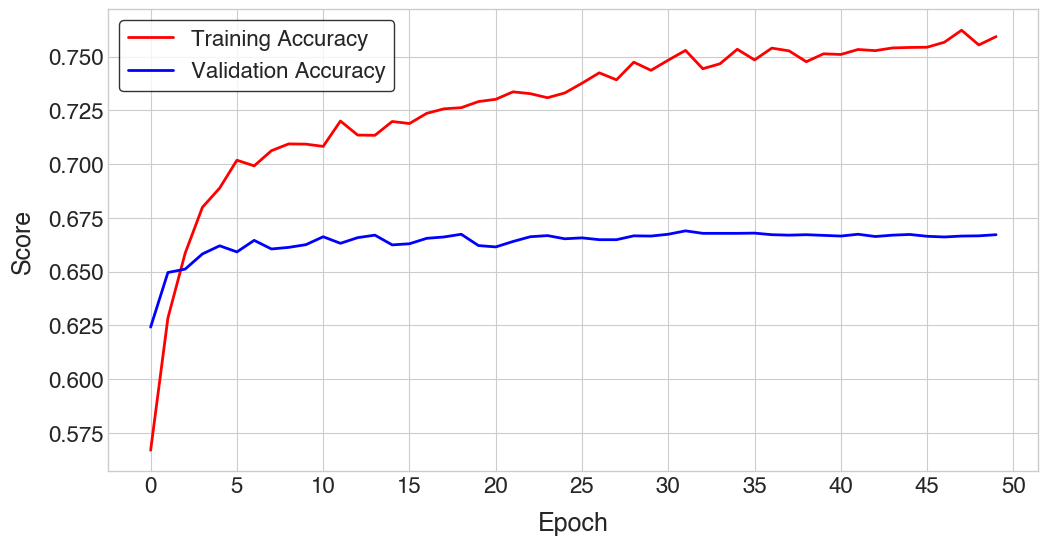

In [21]:
plot_train_proc(df_metrics2, filename='train_proc_2.svg')

In [53]:
preds_proba2_train = model2.predict(X_train).flatten()
preds2_train = (preds_proba2_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds2_train == y_train)/len(y_train):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Training accuracy: 0.758


In [54]:
preds_proba2_test = model2.predict(X_test).flatten()
preds2_test = (preds_proba2_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds2_test == y_test)/len(y_test):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
Test accuracy: 0.667


In [55]:
cmat2 = confusion_matrix(y_true=y_test, y_pred=preds2_test)
cmat2_disp = ConfusionMatrixDisplay(cmat2, display_labels=y_encoder.classes_)

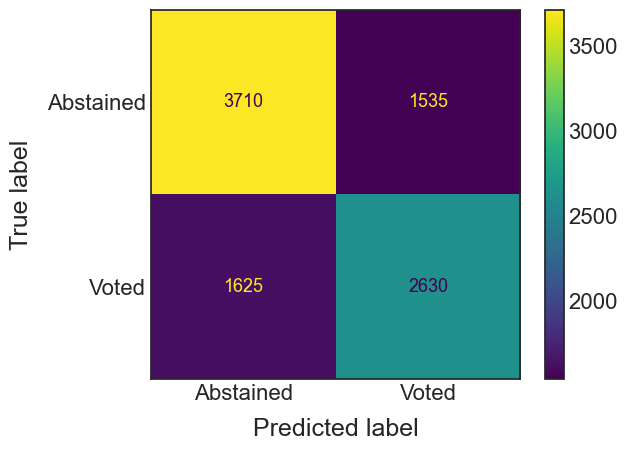

In [56]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat2_disp.plot();

In [57]:
# Additional metrics for performance on test data
metrics2 = Metrics(cmat2)
print(f'Accuracy: {metrics2.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics2.recall():.2%}')
print(f'Specificity (TNR): {metrics2.specificity():.2%}')
print(f'Precision: {metrics2.precision():.2%}')
print(f'F1: {metrics2.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba2_test):.2f}')

Accuracy: 66.74%
Sensitivity/Recall (TPR): 61.81%
Specificity (TNR): 70.73%
Precision: 63.15%
F1: 0.62
AUC: 0.72


## Explain

In [58]:
# Create explainer
expl2 = dx.Explainer(model2, X_test, y_test, predict_function=custom_predict)

Preparation of a new explainer is initiated

  -> data              : 9500 rows 217 cols
  -> target variable   : 9500 values
  -> model_class       : keras.models.sequential.Sequential (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x30c4b4040> will be used
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
  -> predicted values  : min = 0.0, mean = 0.438, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
  -> residuals         : min = -1.0, mean = 0.00947, max = 1.0
  -> model_info        : package keras

A new explainer has been created!


In [59]:
# Create dictionary to map original feature names to dummies
features = df_train.drop('VV_primary', axis=1).columns
feat_dict = {feat: [col for col in X_train.columns if col.startswith(feat)] for feat in features}
feat_dict['birthyr'] = ['remainder__birthyr']
feat_dict['citylength_1'] = ['remainder__citylength_1']
feat_dict['addrlength_1'] = ['remainder__addrlength_1']

In [60]:
# Compute variable importance with 10 permutation rounds
var_imp2 = expl2.model_parts(variable_groups=feat_dict, loss_function='1-auc', 
                             N=None, B=10, random_state=42)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
297/297 ━━━

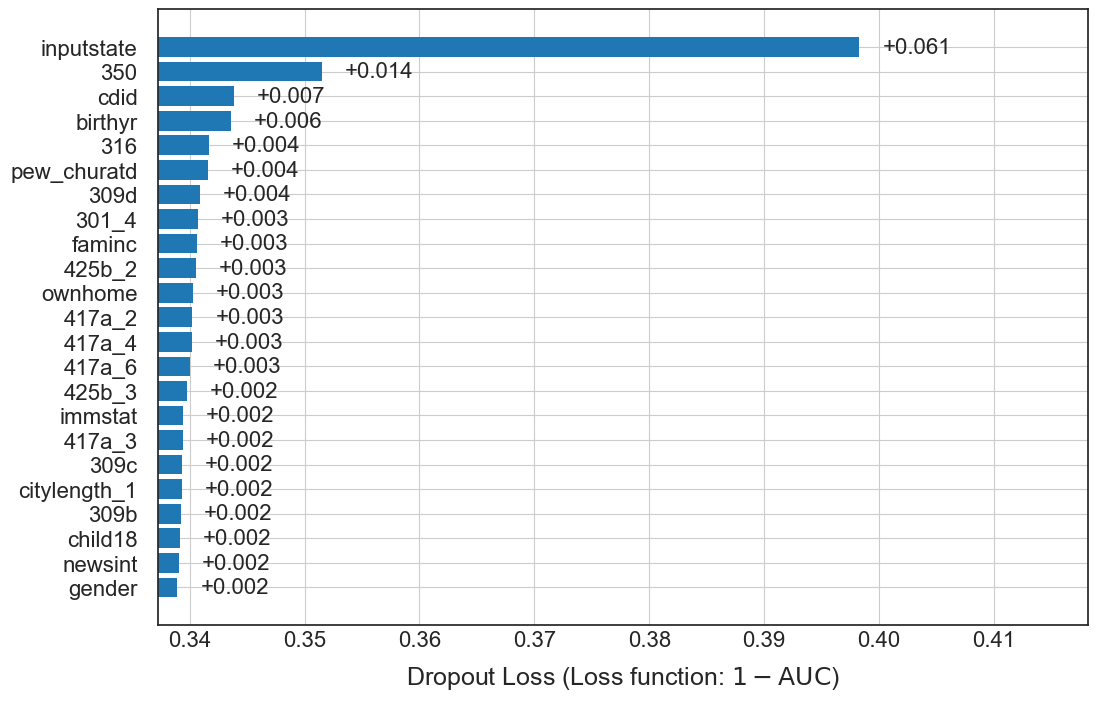

In [61]:
# Plot variable importance
plot_varimp(var_imp2, max_vars=23, file_name='var_imp_2_nn.svg')

# DV: VV_General, incl. lag

## Preprocessing

In [62]:
df_cces_3 = df_cces.drop(['VV_primary_lag', 'VV_primary'], axis=1)

In [63]:
df_train, df_test = split_cces(df_cces_3)

In [64]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [65]:
X_train = df_train.drop('VV_general', axis=1)
y_train = df_train['VV_general'].to_numpy()
X_test = df_test.drop('VV_general', axis=1)
y_test = df_test['VV_general'].to_numpy()

In [66]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [67]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [68]:
# One-hot encode only unordered categorical columns
# Ordered categorical columns are ordinally encoded
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan), 
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [69]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [70]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to test features
X_test = pipe.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [71]:
# Check shape
X_train.shape[1] # 218 features

218

## Import model – No adjustment for class imbalance

In [72]:
# Load model with lowest validation loss
model3 = load_model('../Data/TF+Models/best_model3.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluate

In [22]:
# Visualize training and validation loss during training process
df_metrics3 = pd.read_csv('../Data/TF+Models/training_log3.csv')

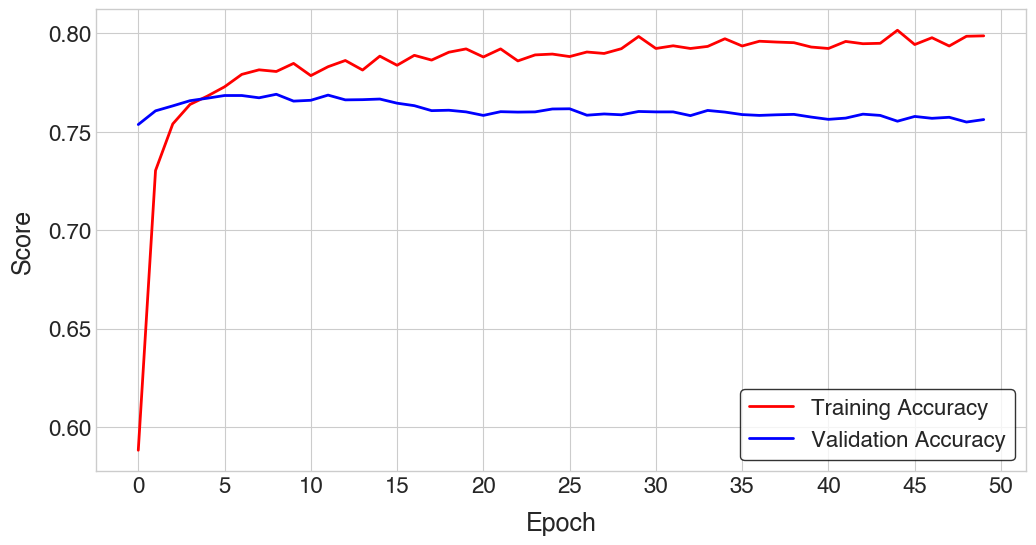

In [23]:
plot_train_proc(df_metrics3, filename='train_proc_3.svg')

In [75]:
preds_proba3_train = model3.predict(X_train).flatten()
preds3_train = (preds_proba3_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds3_train == y_train)/len(y_train):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
Training accuracy: 0.799


In [76]:
preds_proba3_test = model3.predict(X_test).flatten()
preds3_test = (preds_proba3_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds3_test == y_test)/len(y_test):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
Test accuracy: 0.769


## Import model – Class weights


In [77]:
# Load model with lowest validation loss
model4 = load_model('../Data/TF+Models/best_model4.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluate

In [24]:
# Visualize training and validation loss during training process
df_metrics4 = pd.read_csv('../Data/TF+Models/training_log4.csv')

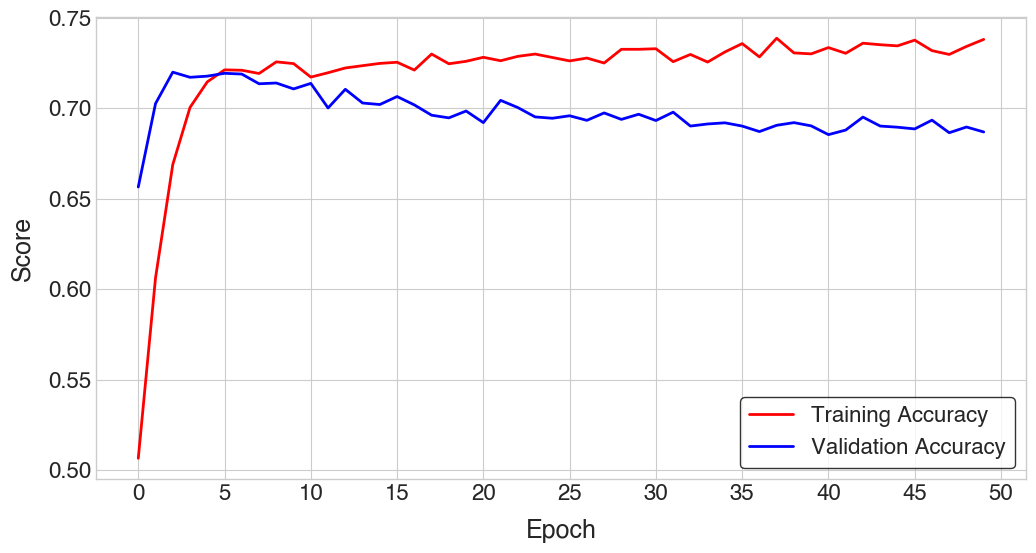

In [25]:
plot_train_proc(df_metrics4, filename='train_proc_4.svg')

In [80]:
preds_proba4_train = model4.predict(X_train).flatten()
preds4_train = (preds_proba4_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds4_train == y_train)/len(y_train):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
Training accuracy: 0.778


In [81]:
preds_proba4_test = model4.predict(X_test).flatten()
preds4_test = (preds_proba4_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds4_test == y_test)/len(y_test):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
Test accuracy: 0.704


In [82]:
cmat4 = confusion_matrix(y_true=y_test, y_pred=preds4_test)
cmat4_disp = ConfusionMatrixDisplay(cmat4, display_labels=y_encoder.classes_)

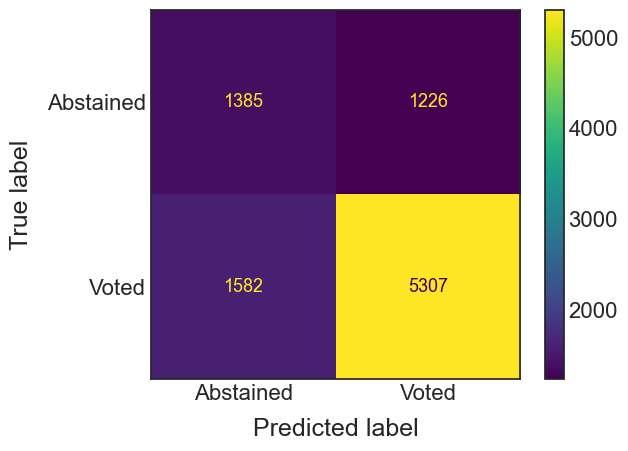

In [83]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat4_disp.plot();

In [84]:
# Additional metrics for performance on test data
metrics4 = Metrics(cmat4)
print(f'Accuracy: {metrics4.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics4.recall():.2%}')
print(f'Specificity (TNR): {metrics4.specificity():.2%}')
print(f'Precision: {metrics4.precision():.2%}')
print(f'F1: {metrics4.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba4_test):.2f}')

Accuracy: 70.44%
Sensitivity/Recall (TPR): 77.04%
Specificity (TNR): 53.04%
Precision: 81.23%
F1: 0.79
AUC: 0.69


## Explain

In [85]:
# Create explainer
expl4 = dx.Explainer(model4, X_test, y_test, predict_function=custom_predict)

Preparation of a new explainer is initiated

  -> data              : 9500 rows 218 cols
  -> target variable   : 9500 values
  -> model_class       : keras.models.sequential.Sequential (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x30c4b4040> will be used
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
  -> predicted values  : min = 0.0, mean = 0.688, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
  -> residuals         : min = -1.0, mean = 0.0375, max = 1.0
  -> model_info        : package keras

A new explainer has been created!


In [86]:
# Create dictionary to map original feature names to dummies
features = df_train.drop('VV_general', axis=1).columns
feat_dict = {feat: [col for col in X_train.columns if col.startswith(feat)] for feat in features}
feat_dict['birthyr'] = ['remainder__birthyr']
feat_dict['citylength_1'] = ['remainder__citylength_1']
feat_dict['addrlength_1'] = ['remainder__addrlength_1']

In [87]:
# Compute variable importance with 10 permutation rounds
var_imp4 = expl4.model_parts(variable_groups=feat_dict, loss_function='1-auc', 
                             N=None, B=10, random_state=42)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
297/297 ━━━

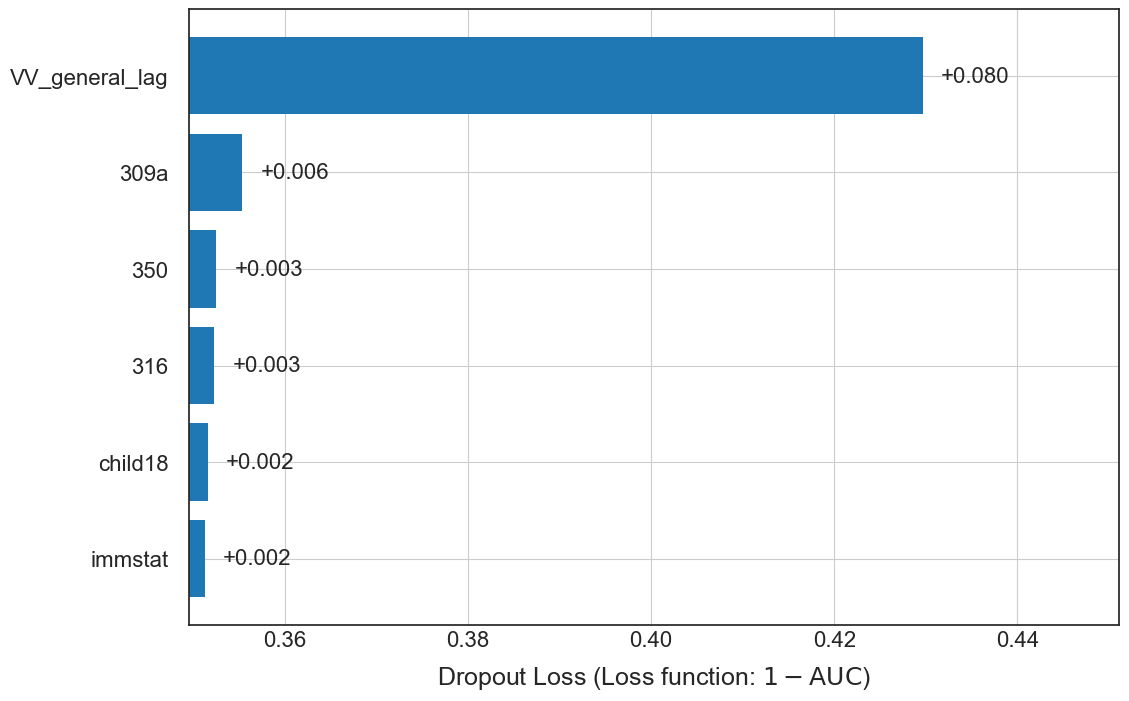

In [88]:
plot_varimp(var_imp4, max_vars=6, file_name='var_imp_4_nn.svg')

# DV: VV_General, excl. lag

## Preprocessing

In [89]:
df_cces_5 = df_cces.drop(['VV_primary_lag', 'VV_primary', 'VV_general_lag'], axis=1)

In [90]:
df_train, df_test = split_cces(df_cces_5)

In [91]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [92]:
X_train = df_train.drop('VV_general', axis=1)
y_train = df_train['VV_general'].to_numpy()
X_test = df_test.drop('VV_general', axis=1)
y_test = df_test['VV_general'].to_numpy()

In [93]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [94]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [95]:
# One-hot encode only unordered categorical columns
# Ordered categorical columns are ordinally encoded
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan), 
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [96]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [97]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to test features
X_test = pipe.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [98]:
# Check shape
X_train.shape[1] # 217 features

217

## Import model – no adjustment for class imbalance

In [99]:
# Load model with lowest validation loss
model5 = load_model('../Data/TF+Models/best_model5.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluate

In [26]:
# Visualize training and validation loss during training process
df_metrics5 = pd.read_csv('../Data/TF+Models/training_log5.csv')

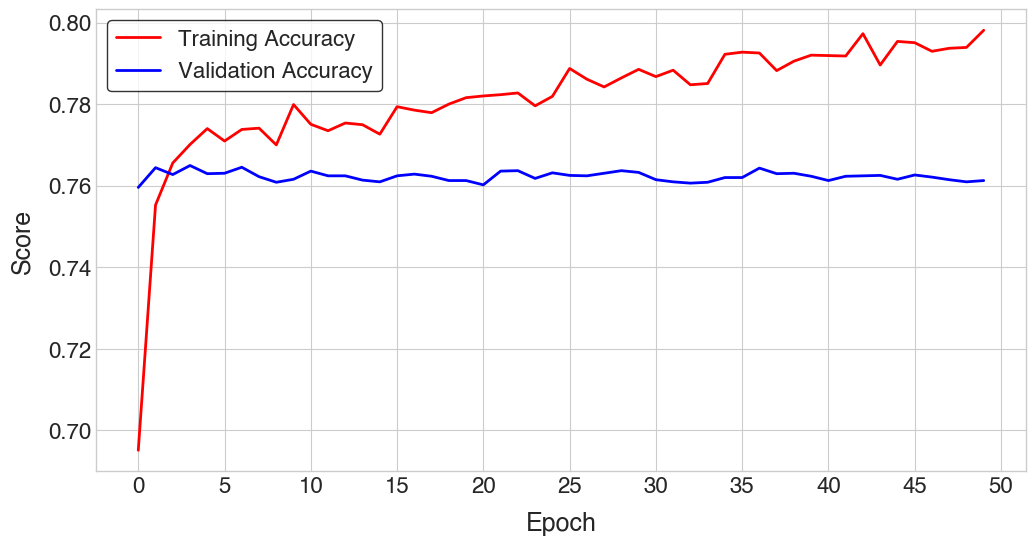

In [27]:
plot_train_proc(df_metrics5, filename='train_proc_5.svg')

In [102]:
preds_proba5_train = model5.predict(X_train).flatten()
preds5_train = (preds_proba5_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds5_train == y_train)/len(y_train):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
Training accuracy: 0.796


In [103]:
preds_proba5_test = model5.predict(X_test).flatten()
preds5_test = (preds_proba5_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds5_test == y_test)/len(y_test):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
Test accuracy: 0.763


## Import model – Class weights

In [104]:
# Load model with lowest validation loss
model6 = load_model('../Data/TF+Models/best_model6.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Evaluate

In [28]:
# Visualize training and validation loss during training process
df_metrics6 = pd.read_csv('../Data/TF+Models/training_log6.csv')

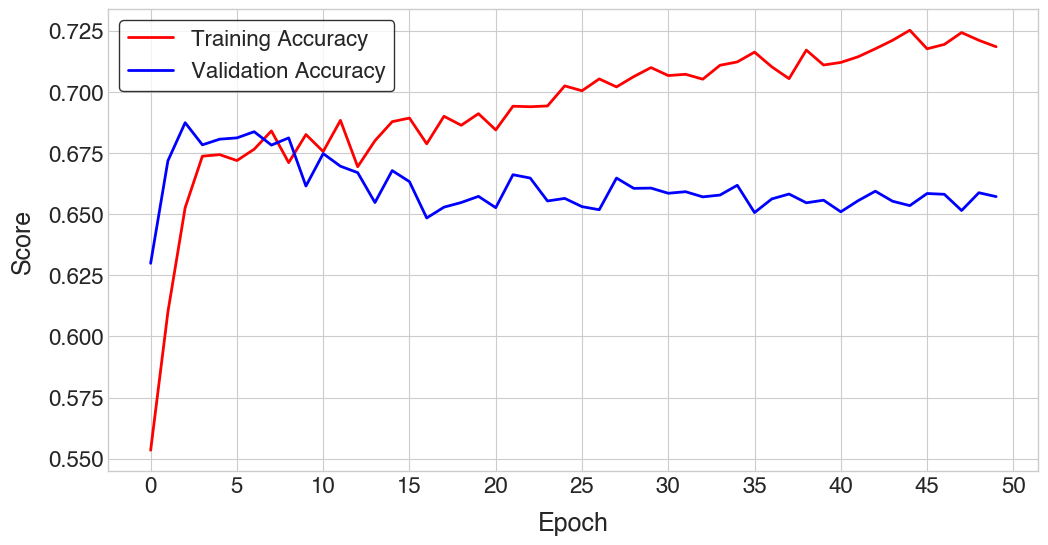

In [29]:
plot_train_proc(df_metrics6, filename='train_proc_6.svg')

In [107]:
preds_proba6_train = model6.predict(X_train).flatten()
preds6_train = (preds_proba6_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds6_train == y_train)/len(y_train):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
Training accuracy: 0.769


In [108]:
preds_proba6_test = model6.predict(X_test).flatten()
preds6_test = (preds_proba6_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds6_test == y_test)/len(y_test):.3f}')

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
Test accuracy: 0.665


In [109]:
cmat6 = confusion_matrix(y_true=y_test, y_pred=preds6_test)
cmat6_disp = ConfusionMatrixDisplay(cmat6, display_labels=y_encoder.classes_)

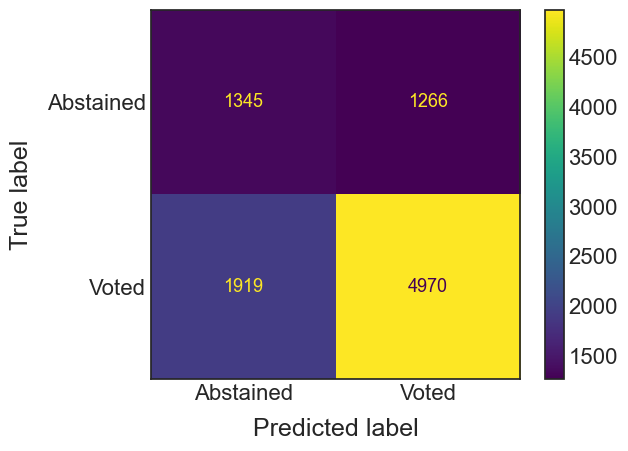

In [110]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat6_disp.plot();

In [111]:
# Additional metrics for performance on test data
metrics6 = Metrics(cmat6)
print(f'Accuracy: {metrics6.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics6.recall():.2%}')
print(f'Specificity (TNR): {metrics6.specificity():.2%}')
print(f'Precision: {metrics6.precision():.2%}')
print(f'F1: {metrics6.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba6_test):.2f}')

Accuracy: 66.47%
Sensitivity/Recall (TPR): 72.14%
Specificity (TNR): 51.51%
Precision: 79.70%
F1: 0.76
AUC: 0.66


## Explain

In [112]:
# Create explainer
expl6 = dx.Explainer(model6, X_test, y_test, predict_function=custom_predict)

Preparation of a new explainer is initiated

  -> data              : 9500 rows 217 cols
  -> target variable   : 9500 values
  -> model_class       : keras.models.sequential.Sequential (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x30c4b4040> will be used
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
  -> predicted values  : min = 0.0, mean = 0.656, max = 1.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
  -> residuals         : min = -1.0, mean = 0.0687, max = 1.0
  -> model_info        : package keras

A new explainer has been created!


In [113]:
# Create dictionary to map original feature names to dummies
features = df_train.drop('VV_general', axis=1).columns
feat_dict = {feat: [col for col in X_train.columns if col.startswith(feat)] for feat in features}
feat_dict['birthyr'] = ['remainder__birthyr']
feat_dict['citylength_1'] = ['remainder__citylength_1']
feat_dict['addrlength_1'] = ['remainder__addrlength_1']

In [114]:
# Compute variable importance with 10 permutation rounds
var_imp6 = expl6.model_parts(variable_groups=feat_dict, loss_function='1-auc', 
                             N=None, B=10, random_state=42)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
297/297 ━━━

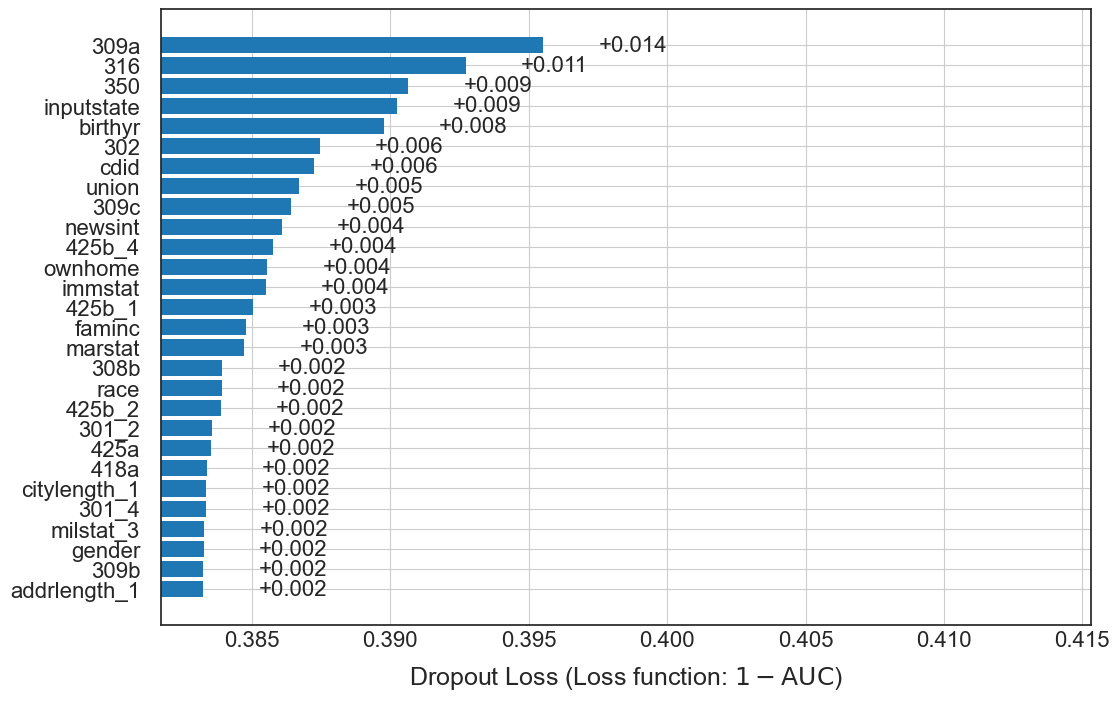

In [115]:
plot_varimp(var_imp6, max_vars=28, file_name='var_imp_6_nn.svg')